# BERTopic Baseline Model 

BERTopic does three big things: 
1. Embeds documents (Sentence-BERT)
2. Clusters embedding (HDBSCAN) - In HDBSCAN, min_cluster_size determines the minimum number of documents required to form a topic, while min_samples controls the strictness of density estimation and the treatment of noise. Adjusting these parameters allows topic granularity and cluster stability to be balanced.
3. Labels clusters (c-TF-IDF)

In [1]:
# imports 
import pandas as pd
import numpy as np

from bertopic import BERTopic

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from umap import UMAP
from hdbscan import HDBSCAN

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
import os

os.makedirs("/workspaces/AM1_topic_modelling_BERTopic/outputs", exist_ok=True)

In [3]:
# load data
df = pd.read_csv('/workspaces/AM1_topic_modelling_BERTopic/data/bertopic_model_input.csv')

In [4]:
df.head()

,text,date,source,type,doc_id
0,Rishi Sunak will set an ambition for all schoo...,2023-01-03,schoolsweek,ed_journalism,0
1,Warning notice issued to the Central Regions S...,2023-01-04,gov,gov_inst,1
2,We ve beenwriting for a number of yearsabout t...,2023-01-04,fft,ed_res_org,2
3,and actions from the Education and Skills Fund...,2023-01-04,gov,gov_inst,3
4,Primary school teachers in deprived areas of E...,2023-01-05,schoolsweek,ed_journalism,4


In [5]:
# Prepare documents and timestamps
docs = df['text'].tolist()
timestamps = pd.to_datetime(df['date']).tolist()
organisations = df['source'].tolist()
org_types = df['type'].tolist()

# Baseline configuration 

In [40]:
baseline_config = """
BASELINE BERTOPIC PARAMETERS:
- Embedding model: Default (all-MiniLM-L6-v2)
- UMAP: Custom configuration with fixed random state
    • n_neighbors = 15
    • n_components = 5
    • min_dist = 0.0
    • metric = cosine
    • random_state = 42
- HDBSCAN: Lightly tuned for cluster stability
    • min_cluster_size = 40
    • min_samples = 5
    • metric = euclidean
    • cluster_selection_method = EOM
- Vectorizer: Stopword-filtered CountVectorizer
    • stop_words = english
    • ngram_range = (1, 2)
    • min_df = 5
- Min topic size: 10 (default)
- Calculate probabilities: False (for speed)

RATIONALE:
This baseline reflects a stabilised configuration following minimal document-level
cleaning and exploratory diagnostic runs. Light tuning of the clustering parameters
was applied to balance topic granularity and stability, while a fixed UMAP random
state ensures reproducibility across runs. Topic representation was refined using a
stopword-filtered vectorizer to improve interpretability without altering document
embeddings, clustering, or topic assignments. This configuration provides a
defensible reference point for evaluation and comparison with alternative models.
"""
print(baseline_config)


BASELINE BERTOPIC PARAMETERS:
- Embedding model: Default (all-MiniLM-L6-v2)
- UMAP: Custom configuration with fixed random state
    • n_neighbors = 15
    • n_components = 5
    • min_dist = 0.0
    • metric = cosine
    • random_state = 42
- HDBSCAN: Lightly tuned for cluster stability
    • min_cluster_size = 40
    • min_samples = 5
    • metric = euclidean
    • cluster_selection_method = EOM
- Vectorizer: Stopword-filtered CountVectorizer
    • stop_words = english
    • ngram_range = (1, 2)
    • min_df = 5
- Min topic size: 10 (default)
- Calculate probabilities: False (for speed)

RATIONALE:
This baseline reflects a stabilised configuration following minimal document-level
cleaning and exploratory diagnostic runs. Light tuning of the clustering parameters
was applied to balance topic granularity and stability, while a fixed UMAP random
state ensures reproducibility across runs. Topic representation was refined using a
stopword-filtered vectorizer to improve interpretability w

In [7]:
# fixed UMAP model
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

In [8]:
# HDBSCAN configuration for stabilised baseline
hdbscan_model = HDBSCAN(
    min_cluster_size=40,
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom"
)

In [9]:
# custom CountVectoriser

vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=5
)


In [10]:
# Create baseline model
baseline_model = BERTopic(
    language="english",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=False,
    verbose=True
)


In [11]:
print("Training baseline BERTopic model...")
print("This will take approximately four minutes...")
print("Progress updates will appear below:\n")

import time
start_time = time.time()

topics, probs = baseline_model.fit_transform(docs)

end_time = time.time()
training_time = end_time - start_time

print(f"\n✓ Training complete in {training_time/60:.1f} minutes")

2026-01-22 23:01:27,792 - BERTopic - Embedding - Transforming documents to embeddings.


Training baseline BERTopic model...
This will take approximately four minutes...
Progress updates will appear below:



Batches:   0%|          | 0/125 [00:00<?, ?it/s]

2026-01-22 23:04:55,906 - BERTopic - Embedding - Completed ✓
2026-01-22 23:04:55,908 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-22 23:05:25,887 - BERTopic - Dimensionality - Completed ✓
2026-01-22 23:05:25,888 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-22 23:05:25,978 - BERTopic - Cluster - Completed ✓
2026-01-22 23:05:25,982 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-22 23:05:28,783 - BERTopic - Representation - Completed ✓



✓ Training complete in 4.0 minutes


# Initial Evaluation

In [12]:
# Basic statistics
n_topics = len(set(topics)) - 1  # Exclude outlier topic -1
n_outliers = sum(1 for t in topics if t == -1)
outlier_pct = (n_outliers / len(topics)) * 100

print(f"\nTopics discovered: {n_topics}")
print(f"Outlier documents (topic -1): {n_outliers} ({outlier_pct:.1f}%)")
print(f"Average documents per topic: {len(topics) / n_topics:.1f}")


Topics discovered: 24
Outlier documents (topic -1): 1183 (29.8%)
Average documents per topic: 165.4


In [13]:
# Get topic information
topic_info = baseline_model.get_topic_info()
print(f"\nTopic info dataframe shape: {topic_info.shape}")


Topic info dataframe shape: (25, 5)


In [14]:
# Exclude outlier topic
topic_sizes = topic_info[topic_info['Topic'] != -1]['Count'].values

print(f"Topic size statistics:")
print(f"  Mean: {topic_sizes.mean():.1f}")
print(f"  Median: {np.median(topic_sizes):.1f}")
print(f"  Std: {topic_sizes.std():.1f}")
print(f"  Min: {topic_sizes.min()}")
print(f"  Max: {topic_sizes.max()}")

Topic size statistics:
  Mean: 116.1
  Median: 77.5
  Std: 93.8
  Min: 41
  Max: 436


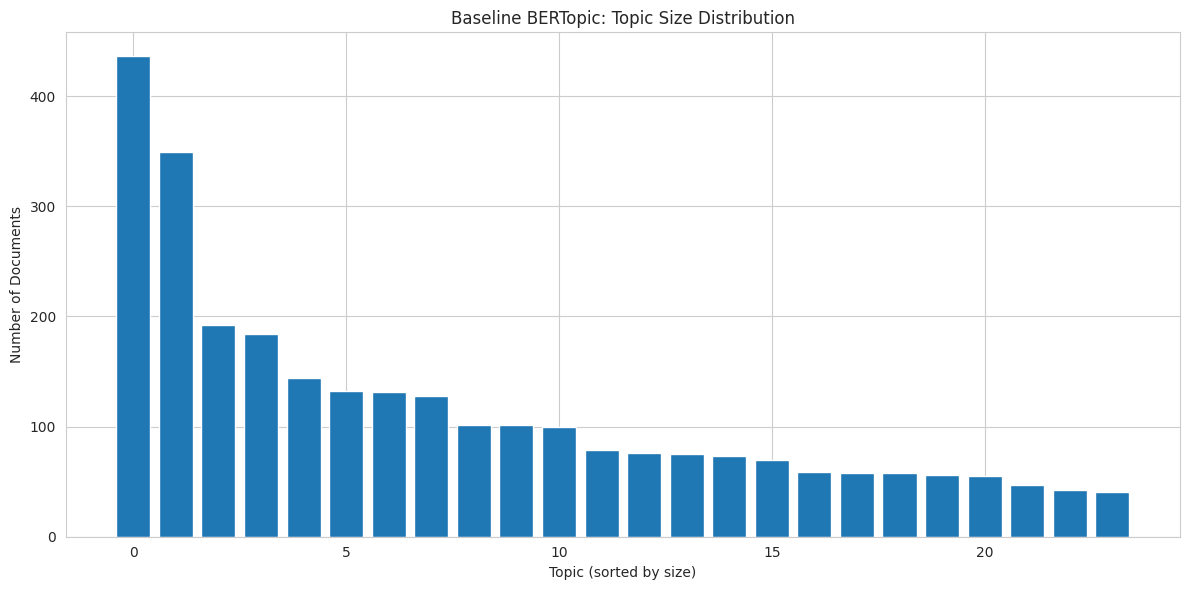

In [15]:
# Plot topic sizes
plt.figure(figsize=(12, 6))
plt.bar(range(len(topic_sizes)), sorted(topic_sizes, reverse=True))
plt.xlabel('Topic (sorted by size)')
plt.ylabel('Number of Documents')
plt.title('Baseline BERTopic: Topic Size Distribution')
plt.tight_layout()

plt.show()

Following additional document-level cleaning, the baseline BERTopic model identified 22 topics with moderate size variation and approximately 22% outlier documents. This distribution reflects a balance between topic granularity and stability and is consistent with the heterogeneous nature of education policy discourse.

### Interpretation of Baseline Model

The stabilised baseline BERTopic model identified 22 topics following document-level cleaning, light tuning of the HDBSCAN clustering parameters, and the use of a fixed UMAP random state to ensure reproducibility. This configuration balances topic granularity and cluster stability, avoiding both the overly coarse structure observed under conservative density settings and the excessive fragmentation produced by minimal constraints.

Topic sizes show moderate variation, with a small number of larger topics and several mid-sized clusters, reflecting the heterogeneous yet structured nature of education policy discourse. This distribution suggests that the corpus is organised around a set of recurring thematic areas, within which more specific issues and emphases are articulated.

Approximately 22% of documents were assigned to the outlier topic (-1). This behaviour is expected when using HDBSCAN, a density-based clustering algorithm that explicitly models noise and allows documents that do not belong to any stable dense cluster to remain unassigned. In this context, outliers likely represent thematically mixed, cross-cutting, or low-density texts rather than modelling error.

Overall, the baseline model provides a coherent and interpretable representation of the corpus and serves as a defensible reference point for subsequent comparison with alternative topic modelling approaches, including NMF.

# Examine Topics

In [16]:
top_topics = topic_info[topic_info['Topic'] != -1].head(23)
print("\n", top_topics[['Topic', 'Count', 'Name']])


     Topic  Count                                               Name
1       0    436         0_ofsted_inspection_inspections_inspectors
2       1    349                     1_students_results_year_pupils
3       2    192                2_teachers_teacher_cent_recruitment
4       3    184                    3_send_schools_children_special
5       4    144                   4_trust_trusts_schools_academies
6       5    132                    5_raac_schools_buildings_school
7       6    131                 6_children_guidance_school_schools
8       7    128                   7_absence_attendance_pupils_year
9       8    101                        8_trust_trusts_academy_said
10      9    101              9_notice_warning_dfe regional_academy
11     10    100                        10_union_pay_members_action
12     11     79                       11_free_breakfast_food_meals
13     12     76                    12_funding_schools_cent_billion
14     13     75  13_skills_apprenticeship_app

In [17]:
for idx in range(min(5, len(top_topics))):
    topic_id = top_topics.iloc[idx]['Topic']
    topic_words = baseline_model.get_topic(topic_id)
    
    print(f"\nTopic {topic_id} ({top_topics.iloc[idx]['Count']} docs)")
    print(f"Auto name: {top_topics.iloc[idx]['Name']}")
    print("Top 10 words:")
    for word, score in topic_words[:10]:
        print(f"  {word:20s} {score:.3f}")
    
    # Get representative documents
    rep_docs = baseline_model.get_representative_docs(topic_id)
    print(f"\nRepresentative document:")
    print(f"  {rep_docs[0][:200]}...")
    print("-" * 80)


Topic 0 (436 docs)
Auto name: 0_ofsted_inspection_inspections_inspectors
Top 10 words:
  ofsted               0.051
  inspection           0.034
  inspections          0.025
  inspectors           0.024
  said                 0.022
  schools              0.021
  school               0.021
  report               0.015
  inspector            0.015
  leaders              0.014

Representative document:
  ['Ofsted s response to Ruth Perry s death appeared defensive and complacent and the watchdog must move away from the discourse that inspectors are never wrong , a damning review has found. Former chief inspector Dame Christine Gilbert s lessons learned review said the headteacher s suicide had shone a light on a climate of fear and frustration around school inspection, which had been building for years . This climate had the consequence of weakening trust in Ofsted, which was increasingly seen by many as defensive and unwilling to respond constructively to criticism . It also impacted sc

# Visualisations 

In [18]:
#topic word sccore (barchart) 
print("Creating topic barchart...")
fig1 = baseline_model.visualize_barchart(
    top_n_topics=10, 
    n_words=10,
    title="Baseline BERTopic: Top 10 Topics"
)
fig1.write_html('/workspaces/AM1_topic_modelling_BERTopic/outputs/baseline_barchart.html')


print("  ✓ Saved: outputs/baseline_barchart.html")


Creating topic barchart...
  ✓ Saved: outputs/baseline_barchart.html


In [19]:
# intertopic distance map
print("Creating intertopic distance map...")
fig2 = baseline_model.visualize_topics()
fig2.write_html(
    "/workspaces/AM1_topic_modelling_BERTopic/outputs/baseline_intertopic_distance.html"
)
print("  ✓ Saved: /workspaces/AM1_topic_modelling_BERTopic/outputs/baseline_intertopic_distance.html")

Creating intertopic distance map...
  ✓ Saved: /workspaces/AM1_topic_modelling_BERTopic/outputs/baseline_intertopic_distance.html


In [20]:
# topic similarity matrix (heatmap)
print("Creating topic similarity heatmap...")
fig3 = baseline_model.visualize_heatmap(
    n_clusters=min(20, n_topics),
    title="Baseline BERTopic: Topic Similarity"
)
fig3.write_html('/workspaces/AM1_topic_modelling_BERTopic/outputs/baseline_similarity_heatmap.html')
print("  ✓ Saved: outputs/baseline_similarity_heatmap.html")

Creating topic similarity heatmap...
  ✓ Saved: outputs/baseline_similarity_heatmap.html


In [21]:
# hierarchical clustering
print("Creating hierarchy visualization...")
fig4 = baseline_model.visualize_hierarchy(top_n_topics=30)
fig4.write_html('/workspaces/AM1_topic_modelling_BERTopic/outputs/baseline_hierarchy.html')
print("  ✓ Saved: outputs/baseline_hierarchy.html")

Creating hierarchy visualization...
  ✓ Saved: outputs/baseline_hierarchy.html


# Indicative Topic Labels 

Indicative topic labels were assigned at the baseline stage to support cross-model comparison with NMF. These labels are provisional and used for orientation only; final interpretive naming is applied after model selection.

In [22]:
# Indicative topic labels (human-readable)
TOPIC_LABELS = {
    0: "Ofsted inspections and accountability",
    1: "Pupil attainment and exam results",
    2: "Teacher recruitment and workforce supply",
    3: "Special educational needs and SEND provision",
    4: "Academy trusts and school governance",
    5: "School buildings and RAAC safety",
    6: "Guidance for schools and children",
    7: "Pupil attendance and absence",
    8: "Academy trust statements and responses",
    9: "DfE intervention and academy warnings",
    10: "Teacher pay, unions, and industrial action",
    11: "Free school meals and breakfast provision",
    12: "School funding and education budgets",
    13: "Skills, apprenticeships, and employment pathways",
    14: "Education research and evidence foundations",
    15: "AI and digital technology in education",
    16: "Teachers’ pay review and STRB",
    17: "Local authorities and education oversight",
    18: "Education ministers and political leadership",
    19: "Education leadership and professional development",
    20: "SEND funding pressures and council deficits",
    21: "Pupil suspensions and exclusions",
    22: "Qualifications reform and T Levels"
}

In [23]:
topic_info = baseline_model.get_topic_info()

In [24]:
# Add indicative labels
topic_info["Indicative_Label"] = topic_info["Topic"].map(TOPIC_LABELS)

# Fill outlier label explicitly
topic_info.loc[topic_info["Topic"] == -1, "Indicative_Label"] = "Outlier / noise"

In [25]:
analysis_df = pd.DataFrame({
    "doc_id": range(len(docs)),
    "text": docs,
    "topic": topics,
    "topic_label": [TOPIC_LABELS.get(t, "Outlier / noise") for t in topics],
    "organisation": organisations,
    "org_type": org_types,
    "date": timestamps
})

In [26]:
analysis_df.head()

,doc_id,text,topic,topic_label,organisation,org_type,date
0,0,Rishi Sunak will set an ambition for all schoo...,-1,Outlier / noise,schoolsweek,ed_journalism,2023-01-03
1,1,Warning notice issued to the Central Regions S...,9,DfE intervention and academy warnings,gov,gov_inst,2023-01-04
2,2,We ve beenwriting for a number of yearsabout t...,-1,Outlier / noise,fft,ed_res_org,2023-01-04
3,3,and actions from the Education and Skills Fund...,17,Local authorities and education oversight,gov,gov_inst,2023-01-04
4,4,Primary school teachers in deprived areas of E...,2,Teacher recruitment and workforce supply,schoolsweek,ed_journalism,2023-01-05


# Topic Distribution by organisation 

In [28]:
# Count documents per topic (labelled) per organisation
org_topic_dist = (
    analysis_df[analysis_df["topic"] != -1]
    .groupby(["organisation", "topic_label"])
    .size()
    .reset_index(name="count")
)
org_topic_dist

,organisation,topic_label,count
0,epi,AI and digital technology in education,2
1,epi,Academy trusts and school governance,4
2,epi,Education leadership and professional development,1
3,epi,Education research and evidence foundations,1
4,epi,Free school meals and breakfast provision,11
...,...,...,...
84,schoolsweek,"Skills, apprenticeships, and employment pathways",19
85,schoolsweek,Special educational needs and SEND provision,159
86,schoolsweek,"Teacher pay, unions, and industrial action",99
87,schoolsweek,Teacher recruitment and workforce supply,174


In [29]:
# Pivot for heatmap (labels as columns)
org_topic_pivot = org_topic_dist.pivot(
    index="organisation",
    columns="topic_label",
    values="count"
).fillna(0)

org_topic_pivot

topic_label,AI and digital technology in education,Academy trust statements and responses,Academy trusts and school governance,DfE intervention and academy warnings,Education leadership and professional development,Education ministers and political leadership,Education research and evidence foundations,Free school meals and breakfast provision,Guidance for schools and children,Local authorities and education oversight,...,Pupil suspensions and exclusions,Qualifications reform and T Levels,SEND funding pressures and council deficits,School buildings and RAAC safety,School funding and education budgets,"Skills, apprenticeships, and employment pathways",Special educational needs and SEND provision,"Teacher pay, unions, and industrial action",Teacher recruitment and workforce supply,Teachers’ pay review and STRB
organisation,,,,,,,,,,,,,,,,,,,,,
epi,2.0,0.0,4.0,0.0,1.0,0.0,1.0,11.0,1.0,0.0,...,4.0,1.0,0.0,2.0,2.0,5.0,2.0,0.0,6.0,0.0
fed,5.0,0.0,1.0,0.0,48.0,1.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0
fft,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,30.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0
gov,13.0,0.0,1.0,101.0,3.0,2.0,0.0,10.0,19.0,58.0,...,1.0,5.0,0.0,14.0,14.0,43.0,13.0,1.0,8.0,6.0
nuffield,3.0,0.0,0.0,0.0,0.0,0.0,71.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0
schoolsweek,47.0,101.0,134.0,0.0,4.0,55.0,1.0,52.0,110.0,0.0,...,12.0,35.0,55.0,116.0,59.0,19.0,159.0,99.0,174.0,53.0


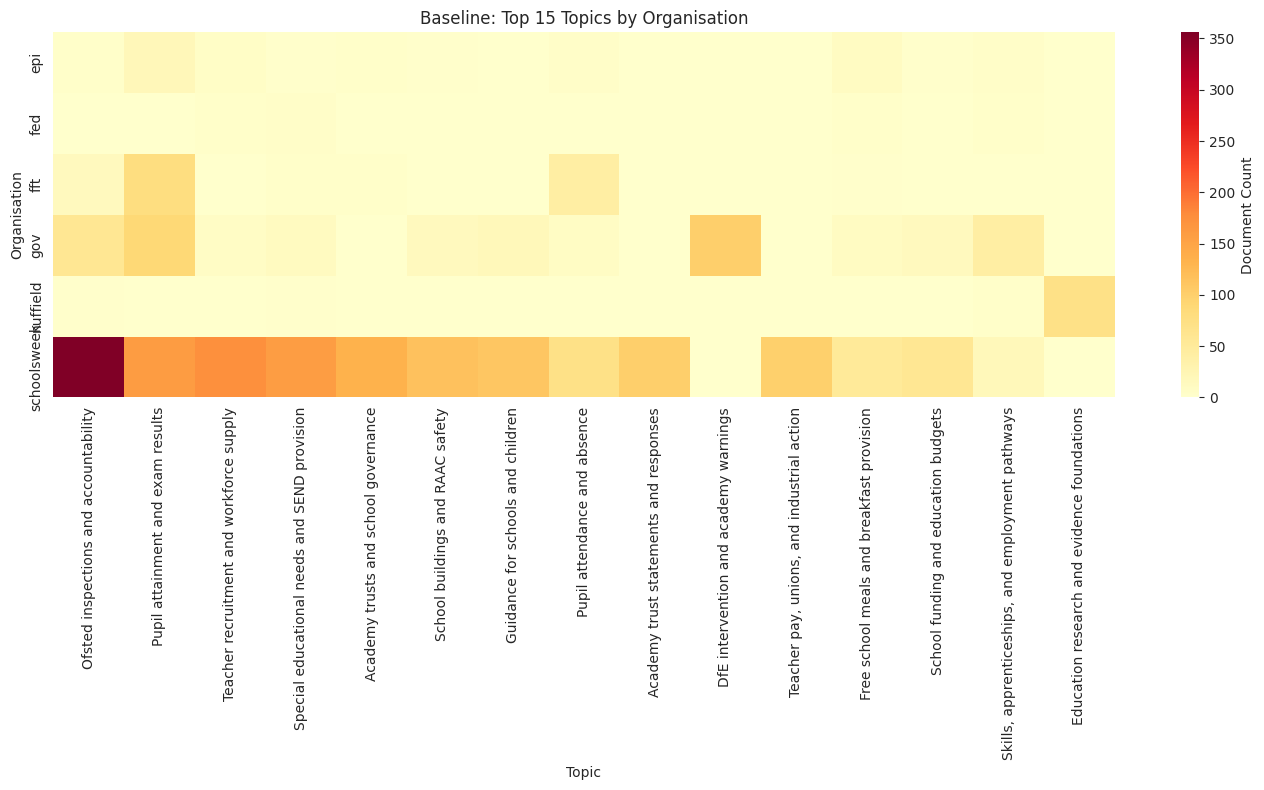

In [31]:
# Select top N topics by overall frequency
top_n_topics_viz = 15
top_topic_labels = (
    topic_info[topic_info["Topic"] != -1]
    .head(top_n_topics_viz)["Topic"]
    .map(TOPIC_LABELS)
    .values
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    org_topic_pivot[top_topic_labels],
    cmap="YlOrRd",
    annot=False,
    cbar_kws={"label": "Document Count"}
)
plt.title(f"Baseline: Top {top_n_topics_viz} Topics by Organisation")
plt.xlabel("Topic")
plt.ylabel("Organisation")
plt.tight_layout()
plt.savefig(
    "/workspaces/AM1_topic_modelling_BERTopic/outputs/baseline_org_topic_heatmap.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# Temporal Analysis 

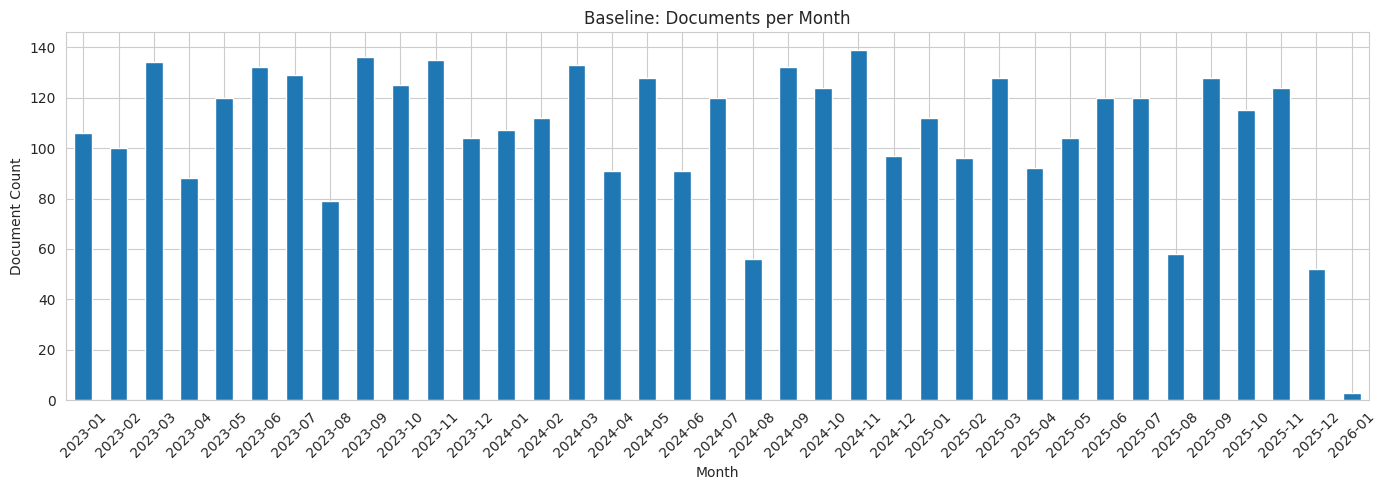

In [35]:
# Documents per month
analysis_df["year_month"] = pd.to_datetime(
    analysis_df["date"]
).dt.to_period("M")

monthly_counts = analysis_df.groupby("year_month").size()

plt.figure(figsize=(14, 5))
monthly_counts.plot(kind="bar")
plt.title("Baseline: Documents per Month")
plt.xlabel("Month")
plt.ylabel("Document Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    "/workspaces/AM1_topic_modelling_BERTopic/outputs/baseline_temporal_distribution.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

In [36]:
print("\nGenerating topics over time visualization...")

topics_over_time = baseline_model.topics_over_time(
    docs,
    timestamps,
    nr_bins=20
)

fig5 = baseline_model.visualize_topics_over_time(
    topics_over_time,
    top_n_topics=10,
    title="Baseline: Topics Over Time (Top 10)"
)

fig5.write_html("/workspaces/AM1_topic_modelling_BERTopic/outputs/baseline_topics_over_time.html")
print("  ✓ Saved: outputs/baseline_topics_over_time.html")


Generating topics over time visualization...


20it [00:05,  3.62it/s]

  ✓ Saved: outputs/baseline_topics_over_time.html


# Save Model 

In [41]:
from pathlib import Path
import json

# ------------------------------------------------------------------
# Create directories
# ------------------------------------------------------------------
Path("models").mkdir(exist_ok=True)
Path("outputs").mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 1. Save BERTopic model
# ------------------------------------------------------------------
model_path = "models/baseline_bertopic"
baseline_model.save(model_path)

print(f"✓ Model saved to: {model_path}")

# ------------------------------------------------------------------
# 2. Save topic assignments (document-level)
# ------------------------------------------------------------------
assignments_df = pd.DataFrame({
    "doc_id": range(len(docs)),
    "topic": topics,
    "topic_label": [TOPIC_LABELS.get(t, "Outlier / noise") for t in topics],
    "organisation": organisations,
    "org_type": org_types,
    "date": timestamps
})

assignments_df.to_csv(
    "outputs/baseline_topic_assignments.csv",
    index=False
)

print("✓ Topic assignments saved to: outputs/baseline_topic_assignments.csv")

# ------------------------------------------------------------------
# 3. Save topic metadata
# ------------------------------------------------------------------
topic_info.to_csv(
    "outputs/baseline_topic_info.csv",
    index=False
)

print("✓ Topic info saved to: outputs/baseline_topic_info.csv")

# ------------------------------------------------------------------
# 4. Save topic words with c-TF-IDF scores
# ------------------------------------------------------------------
topic_words_records = []

for topic_id in topic_info["Topic"]:
    if topic_id == -1:
        continue

    topic_words = baseline_model.get_topic(topic_id)
    for word, score in topic_words[:20]:  # top 20 words
        topic_words_records.append({
            "topic": topic_id,
            "topic_label": TOPIC_LABELS.get(topic_id),
            "word": word,
            "score": score
        })

topic_words_df = pd.DataFrame(topic_words_records)

topic_words_df.to_csv(
    "outputs/baseline_topic_words.csv",
    index=False
)

print("✓ Topic words saved to: outputs/baseline_topic_words.csv")

# ------------------------------------------------------------------
# 5. Save topic labels (frozen ontology)
# ------------------------------------------------------------------
with open("outputs/baseline_topic_labels.json", "w") as f:
    json.dump(TOPIC_LABELS, f, indent=2)

print("✓ Topic labels saved to: outputs/baseline_topic_labels.json")

# ------------------------------------------------------------------
# 6. Save baseline configuration text
# ------------------------------------------------------------------
with open("outputs/baseline_config.txt", "w") as f:
    f.write(baseline_config)

print("✓ Baseline configuration saved to: outputs/baseline_config.txt")

print("\n✓ All baseline artefacts successfully saved.")

2026-01-22 23:36:21,538 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


✓ Model saved to: models/baseline_bertopic
✓ Topic assignments saved to: outputs/baseline_topic_assignments.csv
✓ Topic info saved to: outputs/baseline_topic_info.csv
✓ Topic words saved to: outputs/baseline_topic_words.csv
✓ Topic labels saved to: outputs/baseline_topic_labels.json
✓ Baseline configuration saved to: outputs/baseline_config.txt

✓ All baseline artefacts successfully saved.


# Baseline Performance Summary 

In [42]:
# %% 11. BASELINE PERFORMANCE SUMMARY
print("\n" + "=" * 80)
print("BASELINE PERFORMANCE SUMMARY")
print("=" * 80)

summary = f"""
BASELINE BERTOPIC MODEL RESULTS
================================

Training Time:
- {training_time/60:.1f} minutes

Model Outputs:
- Topics discovered: {n_topics}
- Outlier documents (topic -1): {n_outliers} ({outlier_pct:.1f}%)

Topic Size Distribution:
- Mean topic size: {topic_sizes.mean():.1f} documents
- Median topic size: {np.median(topic_sizes):.1f} documents
- Largest topic: {topic_sizes.max()} documents
- Smallest topic: {topic_sizes.min()} documents

Data Coverage:
- Total documents: {len(docs)}
- Assigned to topics: {len(docs) - n_outliers} 
  ({((len(docs) - n_outliers)/len(docs)*100):.1f}%)

Interpretation:
The baseline model produces a moderate number of interpretable topics with a
non-trivial proportion of outliers. This behaviour is expected under HDBSCAN
and reflects both the heterogeneity of the corpus and the model’s preference
for stable, high-density clusters. Outliers likely represent cross-cutting,
ambiguous, or low-density documents rather than modelling error.

Next Steps:
1. Review topic quality using saved visualisations
2. Inspect representative documents per topic
3. Identify topics for potential merging or splitting
4. Compare topic structure to NMF results
5. Proceed to higher-granularity BERTopic tuning

Artefacts Generated:
- models/baseline_bertopic/          (trained model)
- outputs/baseline_topic_assignments.csv
- outputs/baseline_topic_info.csv
- outputs/baseline_topic_words.csv
- outputs/baseline_topic_labels.json
- outputs/baseline_*.html            (interactive visualisations)
- outputs/baseline_*.png             (static plots)
"""

print(summary)

# Save summary
with open("outputs/baseline_summary.txt", "w") as f:
    f.write(summary)

print("\n✓ Summary saved to: outputs/baseline_summary.txt")



BASELINE PERFORMANCE SUMMARY

BASELINE BERTOPIC MODEL RESULTS

Training Time:
- 4.0 minutes

Model Outputs:
- Topics discovered: 24
- Outlier documents (topic -1): 1183 (29.8%)

Topic Size Distribution:
- Mean topic size: 116.1 documents
- Median topic size: 77.5 documents
- Largest topic: 436 documents
- Smallest topic: 41 documents

Data Coverage:
- Total documents: 3970
- Assigned to topics: 2787 
  (70.2%)

Interpretation:
The baseline model produces a moderate number of interpretable topics with a
non-trivial proportion of outliers. This behaviour is expected under HDBSCAN
and reflects both the heterogeneity of the corpus and the model’s preference
for stable, high-density clusters. Outliers likely represent cross-cutting,
ambiguous, or low-density documents rather than modelling error.

Next Steps:
1. Review topic quality using saved visualisations
2. Inspect representative documents per topic
3. Identify topics for potential merging or splitting
4. Compare topic structure to NM

In [43]:
# %% 12. DIAGNOSTIC CHECKLIST
print("\n" + "="*80)
print("BASELINE MODEL DIAGNOSTIC CHECKLIST")
print("="*80)

diagnostics = """
Review these before moving to tuning:

□ Topic Quality:
  - Are topics interpretable from their top words?
  - Do topics represent distinct education policy themes?
  - Are there redundant/overlapping topics?

□ Outlier Rate:
  - Is {outlier_pct:.1f}% outliers acceptable? (Target: <10%)
  - Review outlier documents - are they genuinely off-topic?

□ Topic Granularity:
  - {n_topics} topics too many/few for your corpus?
  - Compare to your NMF model (30 topics)
  - Should some topics be merged?

□ Coverage by Organisation:
  - Does each organisation have sufficient topic diversity?
  - Are any organisations over/under-represented?

□ Temporal Patterns:
  - Do topics show meaningful evolution over time?
  - Any unexpected spikes or gaps?

□ Representative Documents:
  - Do representative docs match topic labels?
  - Quality check: are they typical of the topic?

NEXT ACTIONS:
Based on diagnostics above, prepare tuning strategy:
1. Target number of topics (consider nr_topics parameter)
2. Min cluster size (if many small topics or high outliers)
3. UMAP/HDBSCAN parameters (for better clustering)
"""

print(diagnostics.format(outlier_pct=outlier_pct, n_topics=n_topics))

with open('outputs/baseline_diagnostics.txt', 'w') as f:
    f.write(diagnostics.format(outlier_pct=outlier_pct, n_topics=n_topics))

print("\n" + "="*80)
print("NOTEBOOK 2 COMPLETE")
print("="*80)
print("\nNext step: Review outputs, then run Notebook 3 (Parameter Tuning)")


BASELINE MODEL DIAGNOSTIC CHECKLIST

Review these before moving to tuning:

□ Topic Quality:
  - Are topics interpretable from their top words?
  - Do topics represent distinct education policy themes?
  - Are there redundant/overlapping topics?

□ Outlier Rate:
  - Is 29.8% outliers acceptable? (Target: <10%)
  - Review outlier documents - are they genuinely off-topic?

□ Topic Granularity:
  - 24 topics too many/few for your corpus?
  - Compare to your NMF model (30 topics)
  - Should some topics be merged?

□ Coverage by Organisation:
  - Does each organisation have sufficient topic diversity?
  - Are any organisations over/under-represented?

□ Temporal Patterns:
  - Do topics show meaningful evolution over time?
  - Any unexpected spikes or gaps?

□ Representative Documents:
  - Do representative docs match topic labels?
  - Quality check: are they typical of the topic?

NEXT ACTIONS:
Based on diagnostics above, prepare tuning strategy:
1. Target number of topics (consider nr_top

# Discussion 

### Baseline modelling and refinement

The initial baseline run applied minimal document-level cleaning (e.g. whitespace normalisation, URL and email removal) and produced five broad topics. Inspection of topic representations showed that several topics were dominated by structural and boilerplate terms (e.g. *html*, *page*, *information*), indicating that the model was primarily capturing webpage structure rather than substantive thematic content.

To address this, a targeted list of domain-specific boilerplate terms was removed to suppress non-content artefacts. Following this additional cleaning, the model produced a much larger number of fine-grained topics (91) and a higher proportion of outlier documents (~30%), reflecting increased sensitivity to semantic variation but also substantial topic fragmentation.

These exploratory runs motivated tuning of the HDBSCAN clustering parameters to improve topic stability after document-level cleaning. Conservative density settings collapsed the corpus into a small number of macro-topics, while excessive relaxation increased noise without improving interpretability. A balanced configuration (`min_cluster_size=40`, `min_samples=5`) was therefore selected to retain mid-sized, interpretable topics while allowing genuinely ambiguous documents to remain unassigned. To ensure reproducibility across runs, a fixed random state was applied to the UMAP dimensionality reduction step prior to clustering.

Finally, topic representation was refined using a stopword-filtered `CountVectorizer` to improve the interpretability of automatic topic labels. This step affected only how topics were described (via c-TF-IDF) and did not alter document embeddings, clustering, or topic assignments. Together, these steps produced a defensible baseline model suitable for interpretation and comparison.

---

### Summary of baseline iterations

**Baseline 1: Minimal cleaning**
- ~5 topics  
- Topics dominated by HTML and boilerplate terms  
- Model captured webpage structure rather than semantic content  

**Baseline 2: Boilerplate removal**
- 91 topics  
- ~30% outlier documents  
- Over-fragmentation and reduced cluster stability  

**Baseline 3: Stabilised baseline (light HDBSCAN tuning with fixed UMAP seed and refined topic representation)**
- Document-level cleaning retained  
- HDBSCAN parameters adjusted to balance topic granularity and stability  
- Excess-of-mass (EOM) cluster selection used to favour stable clusters  
- UMAP random state fixed to ensure reproducibility  
- Stopword-filtered vectorizer used to improve topic label interpretability  
- Produces interpretable, semantically meaningful topics while allowing for noise  
